In [12]:
import os
import re
import json
import matplotlib.pyplot as plt
from datetime import datetime

# For interactive plots
import plotly.graph_objects as go

#                             LOADING & FILTERING                            #
def extract_experiment_name_from_filename(filename, exp_idx):
    """
    Extracts an experiment name from a filename using a specific regex pattern.
    Adjust if your file naming format changes.
    """
    pattern = r'(unet_resnet50|medsam_vit_b)_(\w+)_lr([\d\.]+)_bs(\d+)_(\w+)_(\d+\.?\d*)pct_(\d+)'
    match = re.search(pattern, filename)
    if match:
        model = match.group(1)
        opt = match.group(2)
        lr = match.group(3)
        bs = match.group(4)
        loss = match.group(5)
        ts = match.group(6)
        dt = match.group(7)
        return f"{exp_idx}-{model}_{opt}_lr{lr}_bs{bs}_{loss}_{ts}pct_{dt}"
    return None


def filter_outliers(values, threshold=0.6):
    """
    Filters out values above a certain threshold by turning them into None.
    Helps remove extreme outliers in the data (e.g., from warm-up or logging anomalies).
    """
    return [v if v <= threshold else None for v in values]


def load_metrics_from_directory(directory, threshold=10):
    """
    Loads metrics from all files ending with '_metrics.json' in a given directory.
    Returns a dict: {experiment_name: (train_losses, val_losses, val_dices)}
    """
    results = {}
    exp_idx = 0
    for fname in os.listdir(directory):
        if fname.endswith("_metrics.json"):
            full_path = os.path.join(directory, fname)
            experiment_name = extract_experiment_name_from_filename(fname, exp_idx)
            if experiment_name is None:
                continue
            with open(full_path, "r") as f:
                data = json.load(f)
            train_losses = filter_outliers(data["train_losses"], threshold)
            val_losses = filter_outliers(data["val_losses"], threshold)
            """ train_losses = data["train_losses"]
            val_losses = data["val_losses"] """
            try:
                val_dices = data["val_dices"]
            except:
                continue
            results[experiment_name] = (train_losses, val_losses, val_dices)
            exp_idx += 1
            
    return results

#                           PLOTTING UTILITIES                               #
def ewma(data, weight):
    """
    Exponentially Weighted Moving Average of the values in `data`.
    This is used to smooth out curves.
    """
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in data:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1 - (weight ** num_acc) if weight != 1 else 1
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)
    return smoothed


def plot_interactive_line(metrics_dict, title="", metric_label="Metric", smooth_weight=0.75):
    """
    Creates an interactive Plotly line chart for each experiment in metrics_dict.
    - metrics_dict: {experiment_name: [values_per_epoch], ...}
    - title: Title of the figure
    - metric_label: Y-axis label (e.g. "Loss", "dice", etc.)
    - smooth_weight: EWMA smoothing weight in [0,1). 0 => no smoothing, ~0.75 recommended.

    The figure is displayed in a window or notebook cell. 
    """
    fig = go.Figure()

    for experiment_name, values in sorted(metrics_dict.items()):
        # Filter None
        valid_vals = [(i+1, v) for i, v in enumerate(values) if v is not None]
        if not valid_vals:
            continue

        epochs, vals = zip(*valid_vals)
        # Smooth the curve
        smoothed_vals = ewma(
            vals, smooth_weight) if smooth_weight < 1.0 else vals

        fig.add_trace(go.Scatter(
            x=epochs,
            y=smoothed_vals,
            mode='lines',
            name=experiment_name
        ))

    fig.update_layout(
        title=title,
        xaxis_title="Epoch",
        yaxis_title=metric_label,
        hovermode="x unified",
        width=1200,             # Increase figure width
        height=600,             # Increase figure height
        legend=dict(
            font=dict(size=12),          # Increase legend font size
            title='Experiments',         # Legend title
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),
        hoverlabel=dict(
            font_size=14                 # Increase hover label font size
        )
    )

    fig.show()


def plot_min_max_scatter(metrics_dict, metric_label="Metric", out_png=None):
    """
    Creates a scatter plot where each experiment has two points:
    - The minimum value of the metric
    - The maximum value of the metric
    """
    experiments = list(metrics_dict.keys())
    min_vals = []
    max_vals = []

    for experiment_name in experiments:
        values = metrics_dict[experiment_name]
        filtered_values = [v for v in values if v is not None]
        if filtered_values:
            min_vals.append(min(filtered_values))
            max_vals.append(max(filtered_values))
        else:
            min_vals.append(None)
            max_vals.append(None)

    plt.figure(figsize=(8, 4))
    plt.scatter(min_vals, experiments,  label='Min Value',
                color='blue', marker='o')
    plt.scatter(max_vals, experiments, label='Max Value',
                color='red', marker='x')
    
    # Annotate each point with its actual value
    for i, experiment in enumerate(experiments):
        if min_vals[i] is not None:
            plt.text(min_vals[i], experiment, f"{min_vals[i]:.2f}", fontsize=10, 
                     verticalalignment="center", horizontalalignment="right", color='blue')
        if max_vals[i] is not None:
            plt.text(max_vals[i], experiment, f"{max_vals[i]:.2f}", fontsize=10, 
                     verticalalignment="center", horizontalalignment="left", color='red')


    plt.xticks(rotation=90)
    plt.xlabel(metric_label)
    plt.title(f"Min/Max {metric_label} per Experiment")
    plt.legend(loc="right")
    plt.grid(True)

    if out_png:
        plt.savefig(out_png, bbox_inches='tight')
    plt.show()


def plot_boxplot(metrics_dict, metric_label="Metric Distribution", out_png=None):
    """
    Creates a box plot for each experiment, displaying the distribution
    of metric values across epochs.
    """
    experiments = list(metrics_dict.keys())
    values_list = []

    for e in experiments:
        vals = [v for v in metrics_dict[e] if v is not None]
        values_list.append(vals)

    plt.figure(figsize=(8, 4))
    plt.boxplot(values_list, tick_labels=experiments,
                vert=False, patch_artist=True)
    plt.xticks(rotation=90)
    plt.ylabel(metric_label)
    plt.title(f"Boxplot of {metric_label} per Experiment")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    if out_png:
        plt.savefig(out_png, bbox_inches='tight')
    plt.show()

In [13]:
# Paths to your experiment metrics
medsam_metrics_dir = "/home/fonta42/Desktop/masters-degree/experiments/med-sam/metrics"
unet_metrics_dir   = "/home/fonta42/Desktop/masters-degree/experiments/u-net/metrics"

# Load data
medsam_data = load_metrics_from_directory(medsam_metrics_dir)
unet_data   = load_metrics_from_directory(unet_metrics_dir)

# Prepare date for filenames
current_date = datetime.now()
formatted_date = current_date.strftime("%d_%m_%Y")

# Extract train losses, val losses, and val dice from each dictionary
unet_train_losses = {ts: values[0] for ts, values in unet_data.items()}
unet_val_losses   = {ts: values[1] for ts, values in unet_data.items()}
unet_val_dice      = {ts: values[2] for ts, values in unet_data.items()}

medsam_train_losses = {ts: values[0] for ts, values in medsam_data.items()}
medsam_val_losses   = {ts: values[1] for ts, values in medsam_data.items()}
medsam_val_dice      = {ts: values[2] for ts, values in medsam_data.items()}

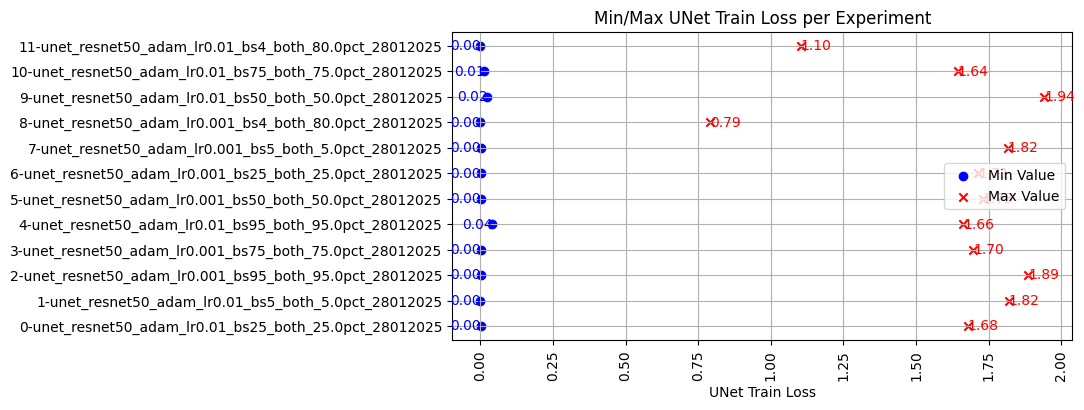

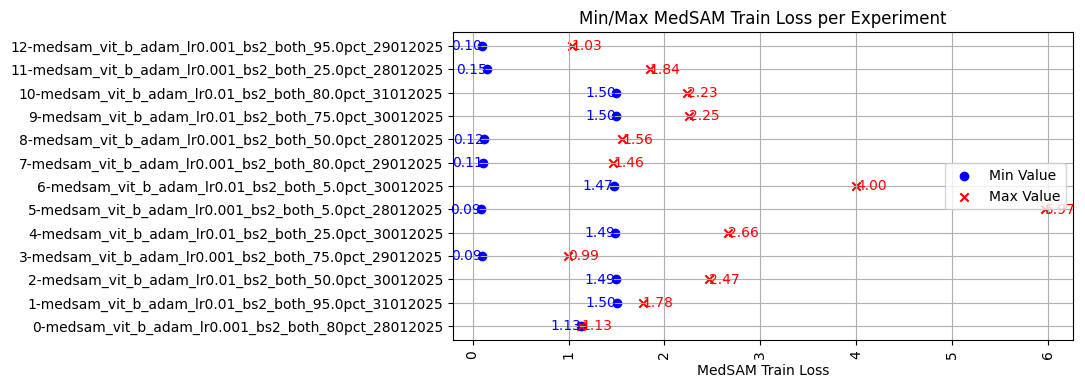

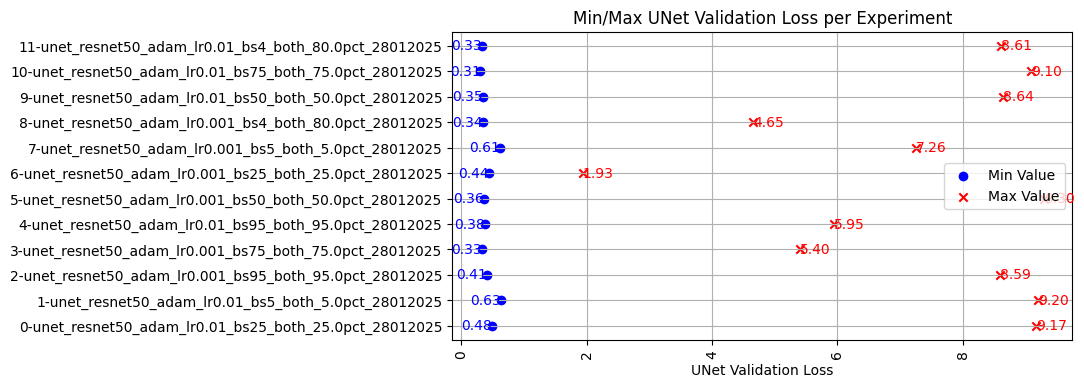

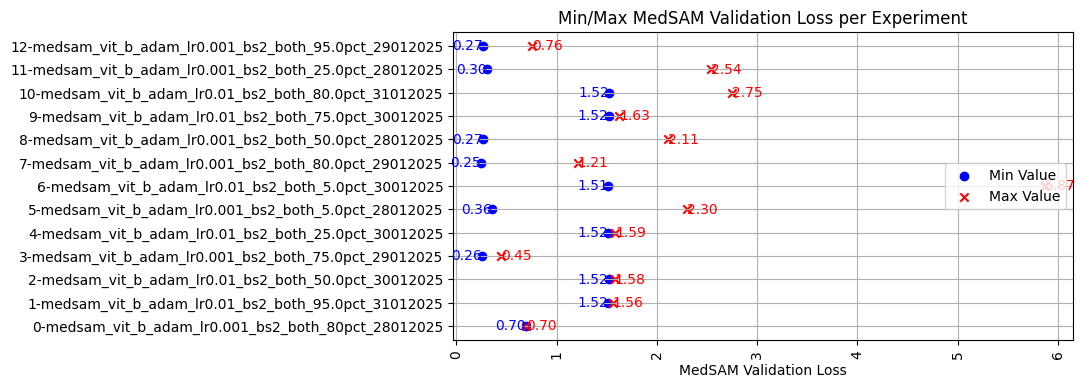

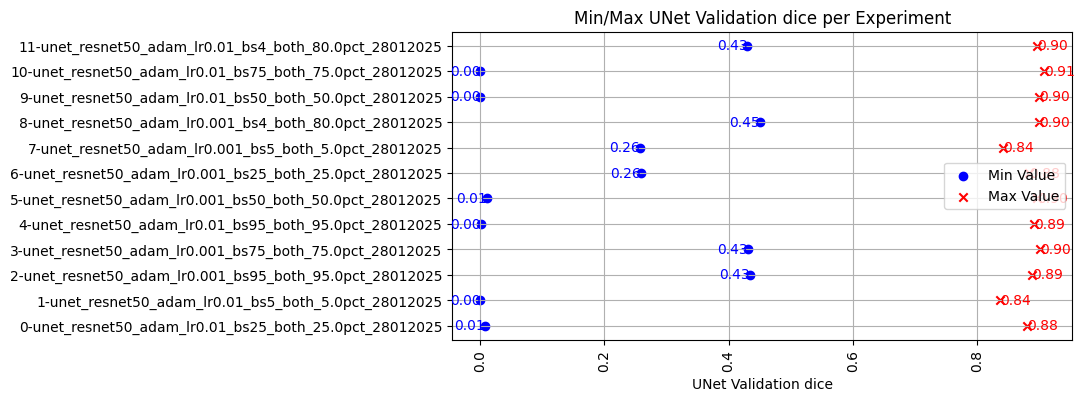

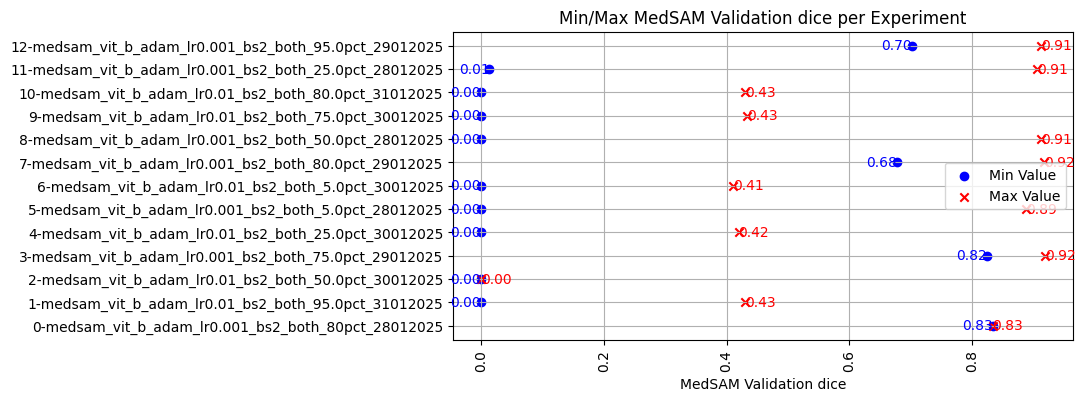

In [14]:
# Scatter plots (Min/Max) for each model's metrics
# UNet Train Losses (min/max)
plot_min_max_scatter(
    unet_train_losses,
    metric_label="UNet Train Loss",
    out_png=f"./metrics_overview/unet_train_loss_min_max_{formatted_date}.png"
)
# MedSAM Train Losses
plot_min_max_scatter(
    medsam_train_losses,
    metric_label="MedSAM Train Loss",
    out_png=f"./metrics_overview/medsam_train_loss_min_max_{formatted_date}.png"
)
# UNet Val Losses
plot_min_max_scatter(
    unet_val_losses,
    metric_label="UNet Validation Loss",
    out_png=f"./metrics_overview/unet_val_loss_min_max_{formatted_date}.png"
)

# MedSAM Val Losses
plot_min_max_scatter(
    medsam_val_losses,
    metric_label="MedSAM Validation Loss",
    out_png=f"./metrics_overview/medsam_val_loss_min_max_{formatted_date}.png"
)
# UNet Val dice
plot_min_max_scatter(
    unet_val_dice,
    metric_label="UNet Validation dice",
    out_png=f"./metrics_overview/unet_val_dice_min_max_{formatted_date}.png"
)
# MedSAM Val dice
plot_min_max_scatter(
    medsam_val_dice,
    metric_label="MedSAM Validation dice",
    out_png=f"./metrics_overview/medsam_val_dice_min_max_{formatted_date}.png"
)

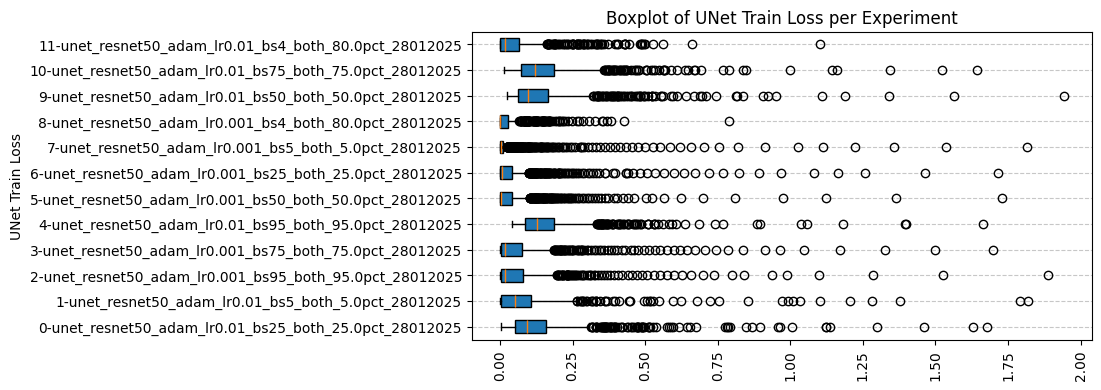

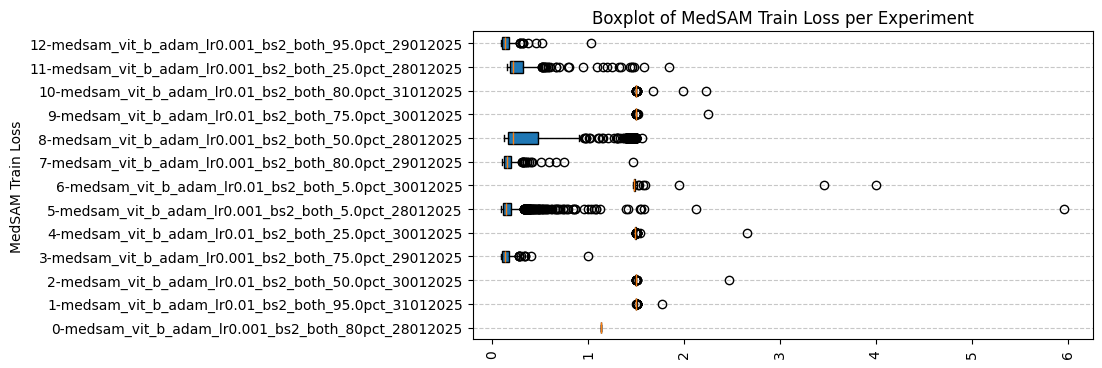

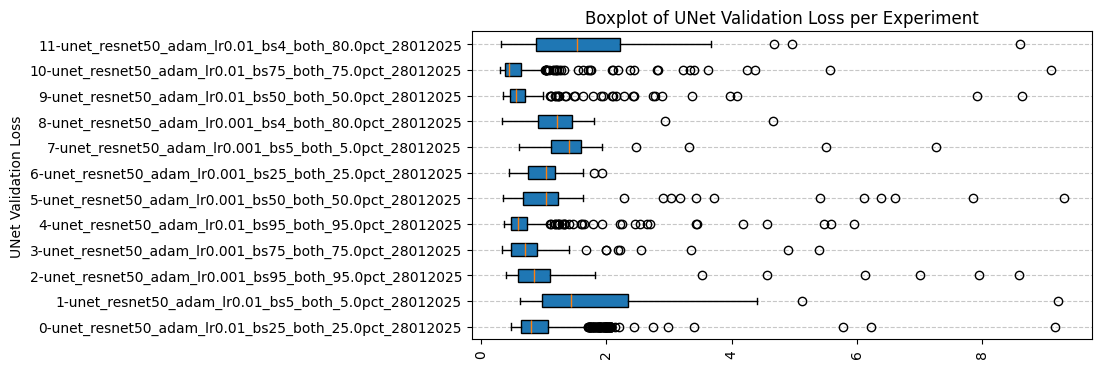

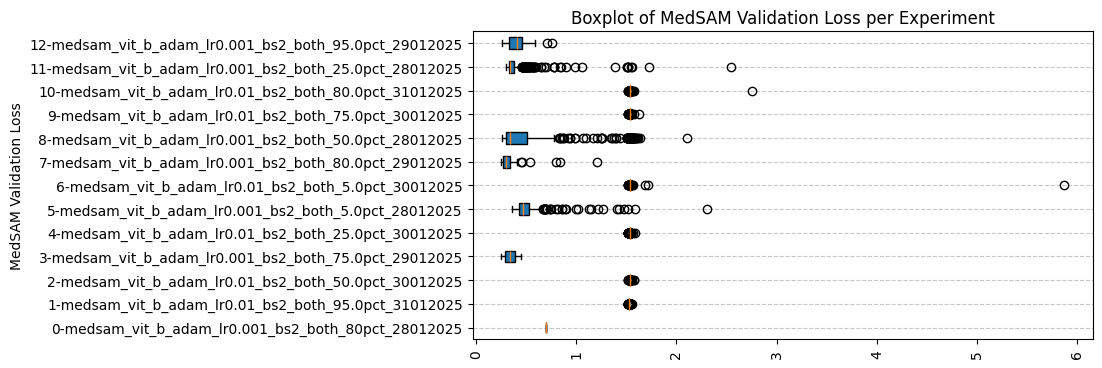

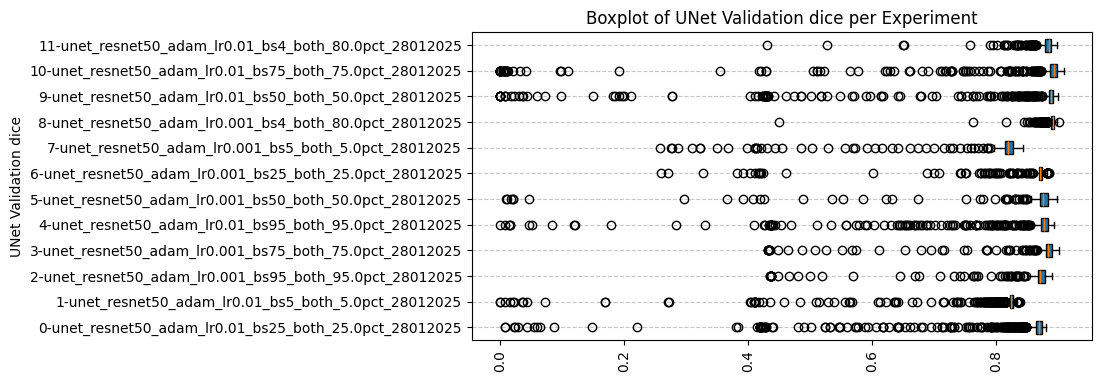

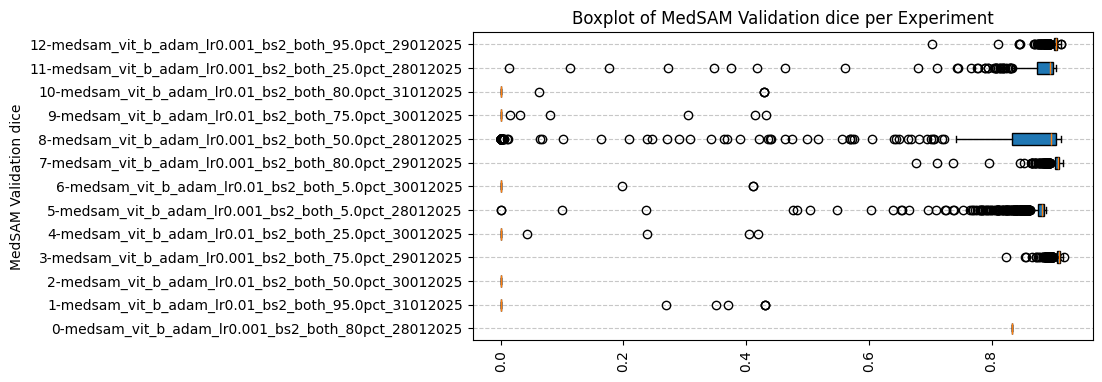

In [15]:
# Box Plots for each model's metrics
plot_boxplot(
    unet_train_losses,
    metric_label="UNet Train Loss",
    out_png=f"./metrics_overview/unet_train_loss_boxplot_{formatted_date}.png"
)

plot_boxplot(
    medsam_train_losses,
    metric_label="MedSAM Train Loss",
    out_png=f"./metrics_overview/medsam_train_loss_boxplot_{formatted_date}.png"
)

plot_boxplot(
    unet_val_losses,
    metric_label="UNet Validation Loss",
    out_png=f"./metrics_overview/unet_val_loss_boxplot_{formatted_date}.png"
)

plot_boxplot(
    medsam_val_losses,
    metric_label="MedSAM Validation Loss",
    out_png=f"./metrics_overview/medsam_val_loss_boxplot_{formatted_date}.png"
)

plot_boxplot(
    unet_val_dice,
    metric_label="UNet Validation dice",
    out_png=f"./metrics_overview/unet_val_dice_boxplot_{formatted_date}.png"
)

plot_boxplot(
    medsam_val_dice,
    metric_label="MedSAM Validation dice",
    out_png=f"./metrics_overview/medsam_val_dice_boxplot_{formatted_date}.png"
)

In [16]:
# Plot Interactive Line Charts (UNet)
# UNet Train Losses
plot_interactive_line(
    unet_train_losses,
    title="UNet Train Losses",
    metric_label="Loss",
    smooth_weight=0.75
)

# UNet Validation Losses
plot_interactive_line(
    unet_val_losses,
    title="UNet Validation Losses",
    metric_label="Loss",
    smooth_weight=0.75
)

""" # MedSAM Train Losses
plot_interactive_line(
    medsam_train_losses,
    title="MedSAM Train Losses",
    metric_label="Loss",
    smooth_weight=0.75
) """


' # MedSAM Train Losses\nplot_interactive_line(\n    medsam_train_losses,\n    title="MedSAM Train Losses",\n    metric_label="Loss",\n    smooth_weight=0.75\n) '

In [17]:
# Plot Interactive Line Charts (MedSAM)

# UNet Validation Losses
plot_interactive_line(
    unet_val_losses,
    title="UNet Validation Losses",
    metric_label="Loss",
    smooth_weight=0.75
)



# MedSAM Validation Losses
plot_interactive_line(
    medsam_val_losses,
    title="MedSAM Validation Losses",
    metric_label="Loss",
    smooth_weight=0.75
)

In [18]:
# UNet Validation dice
plot_interactive_line(
    unet_val_dice,
    title="UNet Validation dice",
    metric_label="dice",
    smooth_weight=0.75
)

# MedSAM Validation dice
plot_interactive_line(
    medsam_val_dice,
    title="MedSAM Validation dice",
    metric_label="dice",
    smooth_weight=0.75
)

In [19]:
# Combined Interactive Line Charts (UNet + MedSAM)

# Combined Train Losses
combined_train_losses = {f"{ts}": values[0] for ts, values in unet_data.items()}
combined_train_losses.update({f"{ts}": values[0] for ts, values in medsam_data.items()})
plot_interactive_line(
    combined_train_losses,
    title="Combined UNet and MedSAM Train Losses",
    metric_label="Loss",
    smooth_weight=0.75
)

In [20]:
# Combined Validation Losses
combined_val_losses = {f"{ts}": values[1] for ts, values in unet_data.items()}
combined_val_losses.update({f"{ts}": values[1] for ts, values in medsam_data.items()})
plot_interactive_line(
    combined_val_losses,
    title="Combined UNet and MedSAM Validation Losses",
    metric_label="Loss",
    smooth_weight=0.75
)

In [21]:
# Combined Validation dice
combined_val_dice = {f"{ts}": values[2] for ts, values in unet_data.items()}
combined_val_dice.update({f"{ts}": values[2] for ts, values in medsam_data.items()})
plot_interactive_line(
    combined_val_dice,
    title="Combined UNet and MedSAM Validation dice",
    metric_label="dice",
    smooth_weight=0.75
)